# Laboration 1 Medical Prediction

---

In [184]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, f1_score


In [185]:
cardio_data = pd.read_csv("../Laboration_1_Medical_Prediction/Data/cardio_train.csv", delimiter=";")
cardio_data.drop("id", axis=1, inplace=True)
cardio_data.head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [186]:
cardio_data.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


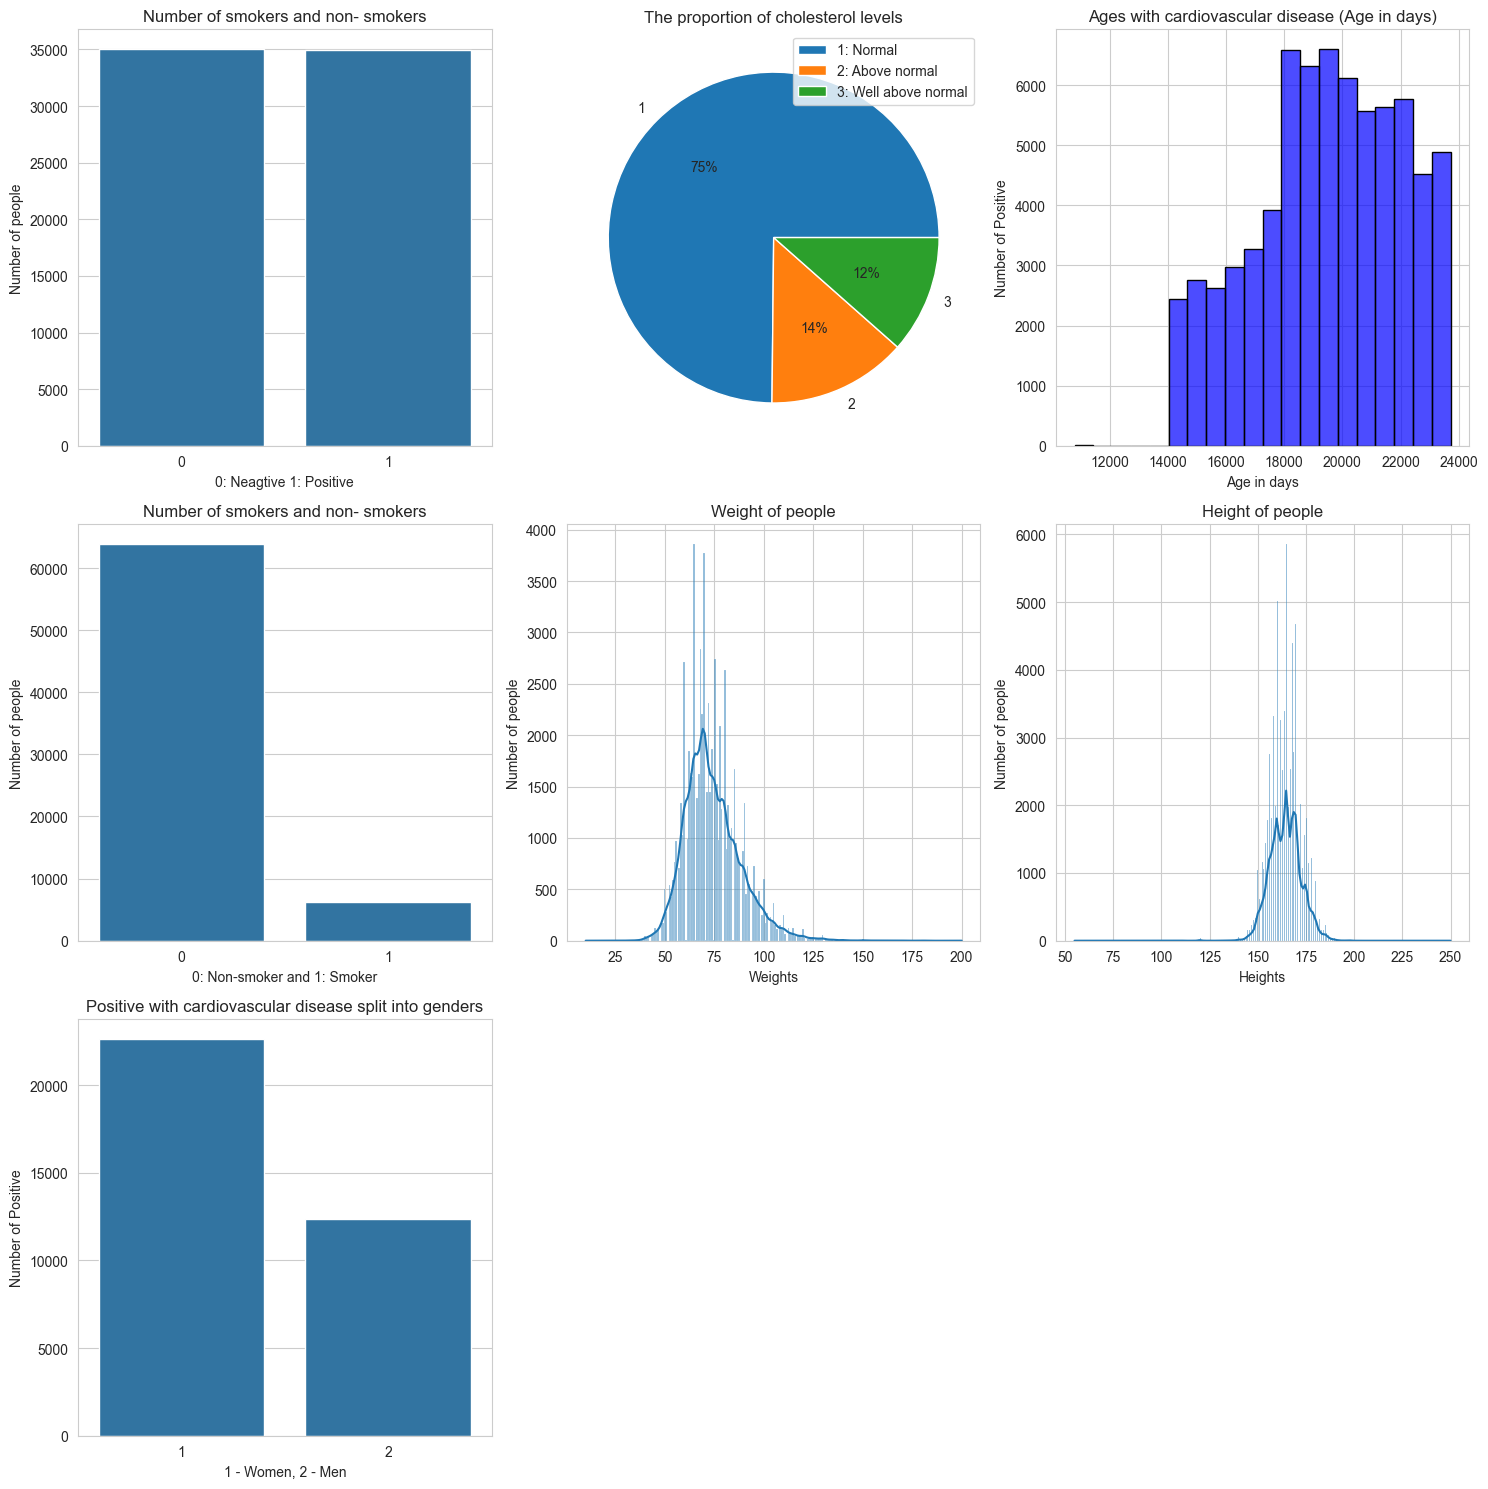

In [187]:
# EDA Plots

fig, axes = plt.subplots(3,3, dpi=100, figsize=(15, 15))

sns.countplot(cardio_data, x="cardio", ax =axes[0, 0])
axes[0, 0].set_xlabel("0: Neagtive 1: Positive")
axes[0, 0].set_ylabel("Number of people")
axes[0, 0].set_title("Number of smokers and non- smokers")

sns.set_style("whitegrid")
axes[0, 1].pie(cardio_data["cholesterol"].value_counts(), labels=["1", "2", "3"], autopct="%.0f%%")
axes[0, 1].set_title("The proportion of cholesterol levels")
axes[0, 1].legend(["1: Normal", "2: Above normal", "3: Well above normal"])

sns.histplot(cardio_data["age"], ax=axes[0, 2], bins=20, color="blue", alpha=0.7, edgecolor="black")
axes[0, 2].set_xlabel("Age in days")
axes[0, 2].set_ylabel("Number of Positive")
axes[0, 2].set_title("Ages with cardiovascular disease (Age in days)")


sns.countplot(data=cardio_data, x="smoke", ax=axes[1, 0])
axes[1, 0].set_xlabel("0: Non-smoker and 1: Smoker")
axes[1, 0].set_ylabel("Number of people")
axes[1, 0].set_title("Number of smokers and non- smokers")


sns.histplot(cardio_data["weight"], kde=True, ax=axes[1, 1])
axes[1, 1].set_xlabel("Weights")
axes[1, 1].set_ylabel("Number of people")
axes[1, 1].set_title("Weight of people")

sns.histplot(cardio_data["height"], kde=True, ax=axes[1, 2])
axes[1, 2].set_xlabel("Heights")
axes[1, 2].set_ylabel("Number of people")
axes[1, 2].set_title("Height of people")


sns.countplot(cardio_data[cardio_data["cardio"] == 1], x="gender", ax=axes[2, 0])
axes[2, 0].set_xlabel("1 - Women, 2 - Men")
axes[2, 0].set_ylabel("Number of Positive")
axes[2, 0].set_title("Positive with cardiovascular disease split into genders");

plt.tight_layout()
fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])


### Formula for BMI

$BMI = \frac{weight_kg}{height_{m^2}}$

In [188]:
def bmi(weight, height):
   """
   Bmi calculator
   
   weight - int, in kilograms
   height - int, in centimeters

   Retrun int - bmi, kg/m^2
   """

   bmi = weight/(height/100)**2

   return bmi

cardio_data["BMI"] = bmi(cardio_data["weight"], cardio_data["height"]) 


In [189]:
percentiles=[.05, .1, .15, .25, .5, .75, .95]
print(f"Looking at the distrubution overwieght \n{cardio_data[cardio_data["BMI"] >= 37]["BMI"].describe(percentiles=percentiles)}\n")

print(f"Looking at the distrubution underweight \n{cardio_data[cardio_data["BMI"] <= 20]["BMI"].describe(percentiles=percentiles)}\n")


Looking at the distrubution overwieght 
count    3826.000000
mean       42.348831
std        12.553911
min        37.015532
5%         37.202381
10%        37.460978
15%        37.664783
25%        38.214990
50%        39.896120
75%        42.914536
95%        52.004123
max       298.666667
Name: BMI, dtype: float64

Looking at the distrubution underweight 
count    1871.000000
mean       18.637331
std         1.338089
min         3.471784
5%         16.326531
10%        17.087445
15%        17.569651
25%        18.125235
50%        19.024970
75%        19.531250
95%        19.903966
max        20.000000
Name: BMI, dtype: float64



---

### Feature engineering BMI


Valde BMI över gräns 54. Tog 95:e percentilen av hela datasetet och satte det som övre gräns först, och plockade ut alla värden över den. Kollade vad medelvärdet och standardavvikelsen var, och tog sedan gränsen för standardavvikelsen över medelvärdet, vilket blev 54. Syftet var att få en rimlig fördelning av dem som skulle klassas som mycket överviktiga. Att mycket överviktiga skulle vara outliers var givet i min mening.

Gjorde också en sökning för att bekräfta min gränssättning. NHS i Storbritannien gav en övre gräns, BMI-artikeln på Wikipedia och CDC i USA angav att BMI över 40 räknas som mycket överviktig. Detta gav rimlighet till att sätta gränsen vid 54. För att hitta kategorierna normalvikt, övervikt, fetma (klass I), fetma (klass II) och fetma (klass III) tog jag direkt från CDC och Wikipedia. Intervallet mellan varje klass var +5 i BMI.

Gjorde samma sak för underviktiga och utgick ifrån minimivärdet i hela datasetet. Här tog jag enbart medelvärdet eftersom standardavvikelsen var så låg. Efter att ha jämfört med de tidigare källornas klassificering av normal BMI, stämde det väl med ett lägsta värde på 18.

För jämförelse och egen bekräftelse av hur fördelningen såg ut plottade jag datasetet och använde describe() för att se hur värdena förändrades före och efter borttagning av outliers. Med en något lägre standardavvikelse och en rimlig boxplot kändes min avgränsning 18 till 54 som rimlig, särskilt för de överviktiga. De var ändå relativt tätt fördelade, förutom outliers. Om vi tittar på datasetet innan borttagning av outliers, sticker BMI-värdena tydligt iväg efter 54.

Källor:
NHS: https://www.nhsinform.scot/healthy-living/food-and-nutrition/healthy-eating-and-weight-management/body-mass-index-bmi/
CDC: https://www.cdc.gov/bmi/adult-calculator/bmi-categories.html
Wikipedia: https://en.wikipedia.org/wiki/Body_mass_index

---

In [190]:
# Looking at change in the distribution and values

cardio_bmi = cardio_data[(cardio_data["BMI"] <= 54) & (cardio_data["BMI"] >= 18)]
df_bmi_describe = pd.DataFrame([cardio_data["BMI"].describe(percentiles=percentiles), cardio_bmi["BMI"].describe(percentiles=percentiles)], index=["BMI with outliers", "BMI without outliers"])
df_bmi_describe


,count,mean,std,min,5%,10%,15%,25%,50%,75%,95%,max
BMI with outliers,70000.0,27.556513,6.091511,3.471784,20.936639,22.074100,22.857143,23.875115,26.374068,30.222222,37.385703,298.666667
BMI without outliers,69428.0,27.509789,5.089660,18.017206,21.134863,22.189349,22.920971,23.875115,26.423570,30.222222,37.222992,53.979239


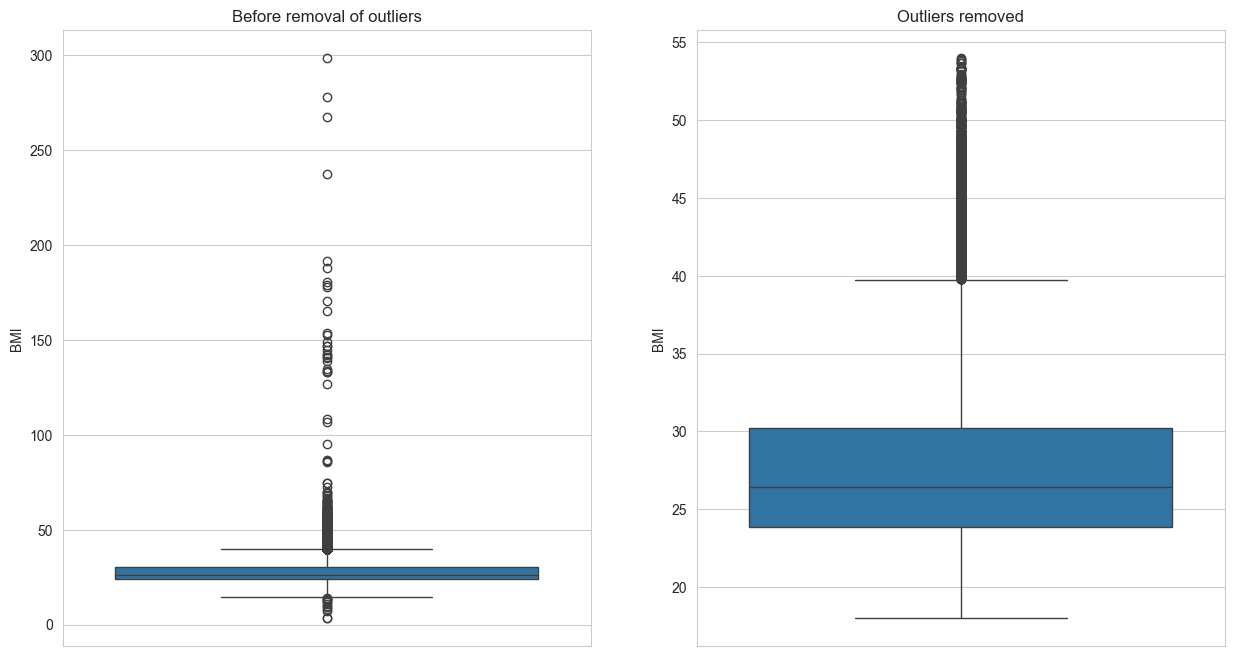

In [191]:
# Visualizing the change in outliers

fig, axes = plt.subplots(1, 2, dpi=100, figsize=(15,8))
sns.boxplot(cardio_data["BMI"],ax=axes[0])
axes[0].set_title("Before removal of outliers")

sns.boxplot(cardio_bmi["BMI"],ax=axes[1])
axes[1].set_title("Outliers removed")
plt.show();

In [192]:
cardio_bmi = cardio_bmi.copy() 
# Too avoid SettingWithCopyWarning error

cardio_bmi["BMI cat"] = pd.cut(cardio_bmi["BMI"], 
                               bins=[18, 25, 30, 35, 40, float("inf")], 
                               labels= ["normal range", "over-weight", "obese (class I)", "obese (class II)", "obese (class III)"])
# Sort BMI data into BMI categories 

In [193]:
cardio_data["ap_lo"].describe(percentiles=[.05, .1, .15, .25, .5, .75, .95])

count    70000.000000
mean        96.630414
std        188.472530
min        -70.000000
5%          70.000000
10%         70.000000
15%         70.000000
25%         80.000000
50%         80.000000
75%         90.000000
95%        100.000000
max      11000.000000
Name: ap_lo, dtype: float64

<Axes: ylabel='ap_lo'>

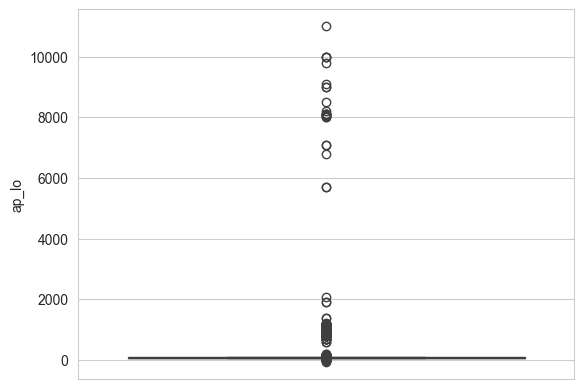

In [194]:
sns.boxplot(cardio_data["ap_lo"])

In [195]:
print(f"High ap_lo:\n{cardio_data[(cardio_data["ap_lo"] >= 100) & (cardio_data["ap_lo"] <= 140)]["ap_lo"].describe(percentiles=percentiles)}\n")
print(f"High ap_hi:\n{cardio_data[(cardio_data["ap_hi"] >= 160) & (cardio_data["ap_hi"] <= 190)]["ap_hi"].describe(percentiles=percentiles)}")

High ap_lo:
count    4839.000000
mean      102.309981
std         6.245909
min       100.000000
5%        100.000000
10%       100.000000
15%       100.000000
25%       100.000000
50%       100.000000
75%       100.000000
95%       120.000000
max       140.000000
Name: ap_lo, dtype: float64

High ap_hi:
count    4745.000000
mean      165.628451
std         8.513678
min       160.000000
5%        160.000000
10%       160.000000
15%       160.000000
25%       160.000000
50%       160.000000
75%       170.000000
95%       180.000000
max       190.000000
Name: ap_hi, dtype: float64


---

### Feature engineering blodtryck

Jag kollade på tabellen som var länkad i materialet för att bestämma den övre gränsen. Tog ett värde mellan den högsta kategorin och den näst högsta som min övre gräns. För långt över den gränsen har man så akuta symptom att det troligen beror på andra yttre faktorer. Om blodtrycket är så högt är man redan på sjukhus och är medveten om eventuella hjärt- och kärlsjukdomar om det är orsaken.

För att kunna förutse om någon har hjärt- och kärlsjukdomar behöver vi identifiera det innan personen hamnar i akut sjukvård.

Det nedre värdet letade jag upp genom att undersöka vid vilket blodtryck allvarliga symptom, som svimning eller suddig syn, börjar uppstå. NHS i Storbritannien angav 90/60 (ap_hi/ap_lo) som gräns, så jag valde ett värde mellan det lägsta normalvärdet från vår länk och detta. Är blodtrycket så lågt att personen svimmar är det en akut situation, och vi kan inte längre förutse något här.

Källa:
NHS: https://www.nhs.uk/conditions/low-blood-pressure-hypotension/

---

In [196]:
cardio_bmi = cardio_bmi[(cardio_bmi["ap_hi"] <= 160) & (cardio_bmi["ap_hi"] >= 90)]
cardio_bmi = cardio_bmi[(cardio_bmi["ap_lo"] <= 120) & (cardio_bmi["ap_lo"] >= 70)]
cardio_bmi.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,63458.000000,63458.000000,63458.000000,63458.000000,63458.000000,63458.000000,63458.000000,63458.000000,63458.000000,63458.000000,63458.000000,63458.000000,63458.000000
mean,19486.303445,1.352391,164.531154,74.309835,126.406017,81.871537,1.363658,1.225756,0.087806,0.053043,0.803571,0.497983,27.486561
std,2456.939324,0.477719,7.814004,13.772631,13.882853,7.821502,0.680027,0.573097,0.283015,0.224121,0.397300,0.500000,5.015480
min,10859.000000,1.000000,109.000000,30.000000,90.000000,70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,18.017206
25%,17711.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,19712.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.397977
75%,21334.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.116213
max,23713.000000,2.000000,207.000000,180.000000,160.000000,120.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,53.979239


<Axes: ylabel='ap_lo'>

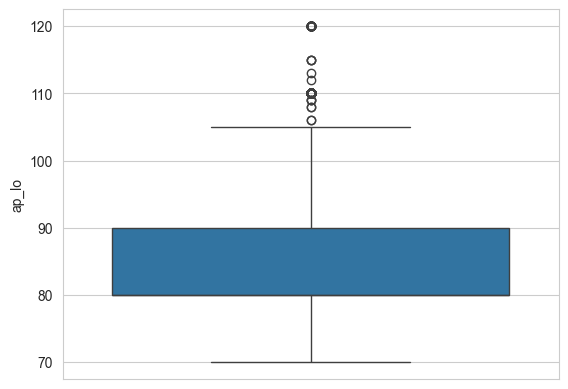

In [197]:
sns.boxplot(cardio_bmi["ap_lo"])

In [198]:
cardio_bmi = cardio_bmi.copy()

for i in cardio_bmi.index:
    ap_hi, ap_lo = cardio_bmi.at[i, "ap_hi"], cardio_bmi.at[i, "ap_lo"]
   
    if ap_hi < 120 and ap_lo < 80:
        cardio_bmi.at[i, "BPR"] = "Healty"
    
    elif 120 <= ap_hi <= 129 and ap_lo < 80:
        cardio_bmi.at[i, "BPR"] = "Elevated"
    
    elif (130 <= ap_hi <= 139) or (80 <= ap_lo <= 89):
        cardio_bmi.at[i, "BPR"] = "Stage 1 hypertension"
   
    elif ap_hi >= 140 or ap_lo >= 90:
        cardio_bmi.at[i, "BPR"] = "Stage 2 hypertension"

cardio_bmi["BPR"].value_counts()

BPR
Stage 1 hypertension    39259
Stage 2 hypertension    14524
Healty                   7096
Elevated                 2579
Name: count, dtype: int64

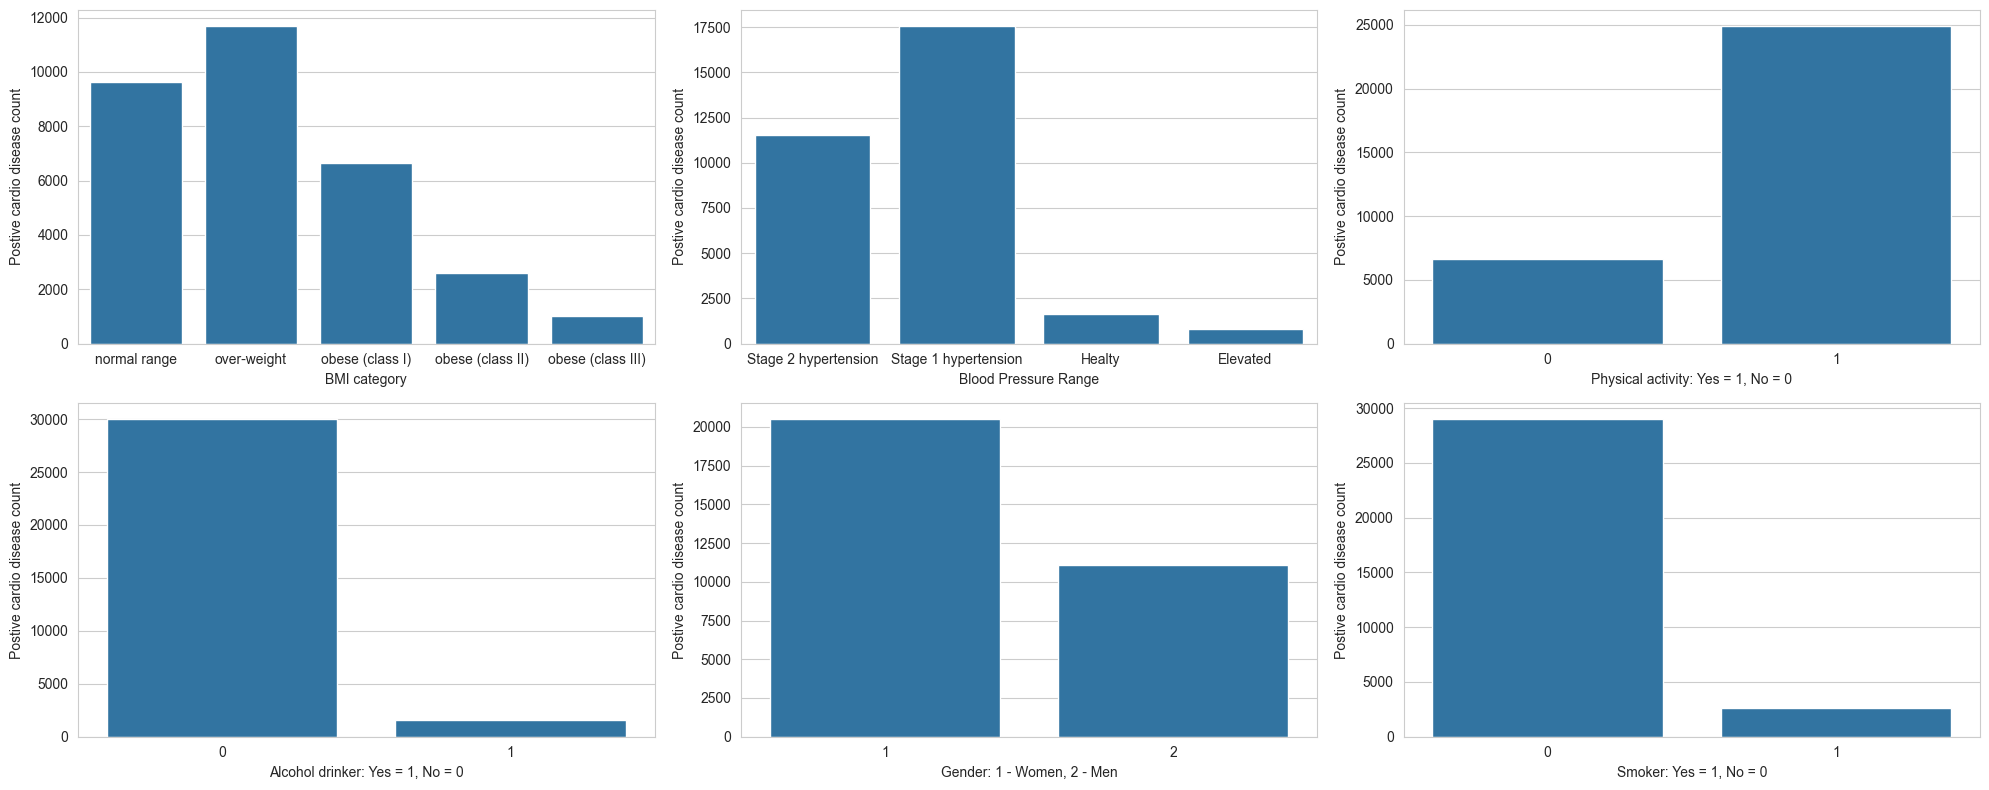

In [199]:
cardio_positive = cardio_bmi[cardio_bmi["cardio"] == 1]
features = ["BMI cat", "BPR", "active", "alco", "gender", "smoke"]
labels = ["BMI category", "Blood Pressure Range", "Physical activity: Yes = 1, No = 0", 
          "Alcohol drinker: Yes = 1, No = 0", "Gender: 1 - Women, 2 - Men", "Smoker: Yes = 1, No = 0"] 

fig, axes = plt.subplots(2, 3, figsize=(20, 8), dpi=100)


for i, ax in enumerate(axes.flatten()):
    sns.countplot(cardio_positive, x=features[i], ax=ax)
    ax.set(xlabel=labels[i], ylabel="Postive cardio disease count")
plt.tight_layout()

<Axes: >

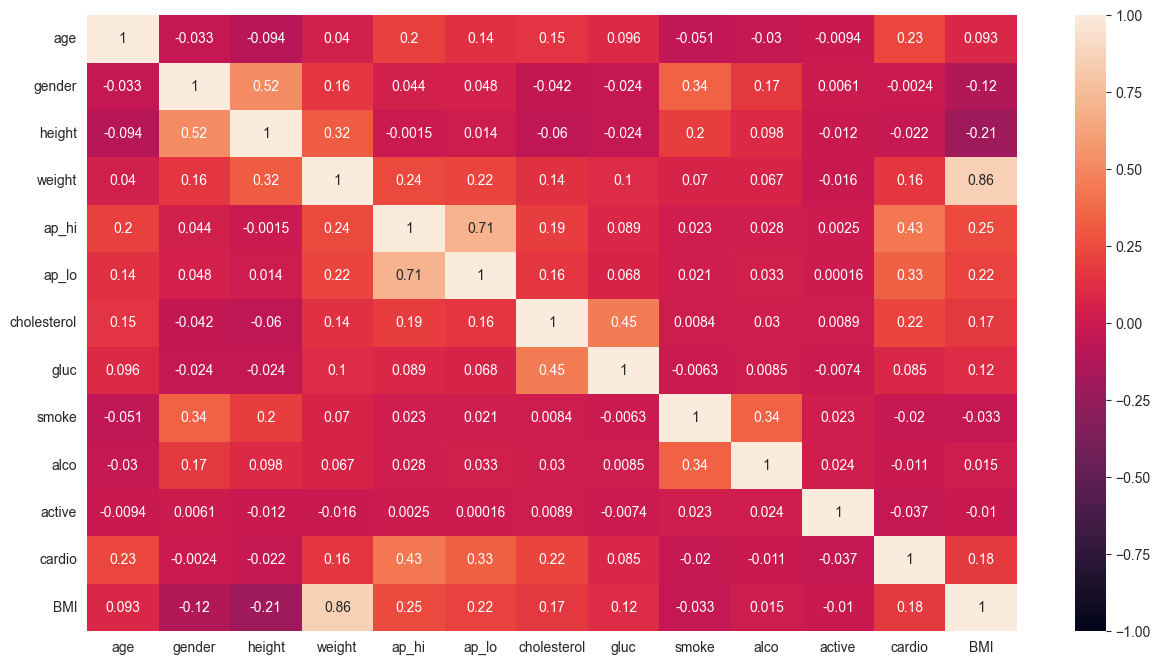

In [200]:
plt.figure(figsize=(15,8))
sns.heatmap(cardio_bmi.corr(numeric_only=True), vmin=-1, vmax=1, annot=True)

---

### Korrelation

Direkt ser vi att vikt har en stark korrelation med BMI. Det beror på att vi beräknar BMI genom att dela vikten med längden. Att längden inte är lika starkt relaterad beror på att vi omvandlar enheterna i BMI-funktionen från centimeter till meter.

Ap_lo och ap_hi är relaterade – de ökar i takt med varandra. Det beror på att de representerar blodtrycksvärden i venerna, beroende på om hjärtat slår eller är i viloläge.

Om vi tittar på cardio, som vi vill förutse, ser vi viss korrelation mellan ap_hi, ap_lo, kolesterol och ålder. Risken ökar med ålder, och höga ap_hi/ap_lo-värden är symptom på hjärt- och kärlsjukdomar. Kolesterol bidrar till utvecklingen av sjukdomen, även om den kopplingen har svag grund i detta dataset – en viss korrelation finns dock.

I övrigt påverkas vikten av kön och längd, vilket sannolikt beror på att män generellt är längre än kvinnor. Kön spelar också en roll när det gäller rökning. Det ser vi i plottarna över rökare mellan könen, där män generellt röker mer.

Slutligen påverkar också sockerintaget kolesterolnivåerna i kroppen. Ett högt sockerintag leder till lägre nivåer av det nyttiga kolesterolet och högre nivåer av det onyttiga. Det framgår dock inte i datasetets information om det är det onyttiga kolesterolet som mätts. Men utifrån egen kunskap vet jag att det är just det onyttiga kolesterolet som ökar vid högre sockerintag.

---

In [201]:
def encoded_df(data, categorical_columns):

    encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoded = encoder.fit_transform(data[categorical_columns])
    data.reset_index(inplace=True)

    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
    cardio_data_encoded = pd.concat([data, one_hot_df], axis=1)
    cardio_data_encoded = cardio_data_encoded.drop(categorical_columns, axis=1)

    return cardio_data_encoded

cardio_data1 = cardio_bmi.drop(["ap_hi", "ap_lo", "height", "weight", "BMI"], axis=1)
categorical_columns1 = ["BMI cat", "BPR", "gender"]
cardio_data1_encoded = encoded_df(cardio_data1, categorical_columns1)

cardio_data2 =  cardio_bmi.drop(["height", "weight", "BMI cat", "BPR"], axis=1)
categorical_columns2 = ["gender"]
cardio_data2_encoded = encoded_df(cardio_data2, categorical_columns2)

cardio_data1_encoded.head()

,index,age,cholesterol,gluc,smoke,alco,active,cardio,BMI cat_normal range,BMI cat_obese (class I),BMI cat_obese (class II),BMI cat_obese (class III),BMI cat_over-weight,BPR_Elevated,BPR_Healty,BPR_Stage 1 hypertension,BPR_Stage 2 hypertension,gender_1,gender_2
0,0,18393,1,1,0,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,20228,3,1,0,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2,18857,3,1,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,3,17623,1,1,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,5,21914,2,2,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(cardio_data1_encoded.drop("cardio",axis=1), cardio_data1_encoded["cardio"], test_size=0.33)
X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(X_val_1, y_val_1, test_size=0.5)

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(cardio_data2_encoded.drop("cardio",axis=1), cardio_data2_encoded["cardio"], test_size=0.33)
X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(X_val_2, y_val_2, test_size=0.5)

X_train_1.shape, X_val_1.shape, X_test_1.shape

((42516, 18), (10471, 18), (10471, 18))

In [203]:
models = {
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

pipelines = {}

for name, model in models.items():
    pipelines[f"{name}_Stdz"] = Pipeline([("scaler", StandardScaler()), ("model", model)])
    pipelines[f"{name}_Norm"] = Pipeline([("scaler", MinMaxScaler()), ("model", model)])

In [204]:
param_grids = {
    "SVM_Stdz": {
        "model__C": [0.1, 1, 10],  
        "model__kernel": ["rbf", "poly"],
        "model__gamma": ["scale", "auto"], 
        "model__degree": [3] 
    },
    "SVM_Norm": {
        "model__C": [0.1, 1, 10],  
        "model__kernel": ["rbf", "poly"],
        "model__gamma": ["scale", "auto"],
        "model__degree": [3]  
    },
    "Logistic Regression_Stdz": {
        "model__C": [0.1, 1, 10],  
        "model__solver": ["saga"],
        "model__max_iter" : [200, 500, 1000],  
        "model__penalty": ["elasticnet"],
        "model__l1_ratio": [0.1, 0.5, 0.9] 
    },
    "Logistic Regression_Norm": {
        "model__C": [0.1, 1, 10],  
        "model__solver": ["saga"],
        "model__max_iter" : [200, 500, 1000],
        "model__penalty": ["elasticnet"],
        "model__l1_ratio": [0.1, 0.5, 0.9]
    },
    "Decision Tree_Stdz": {
        "model__criterion": ["gini", "entropy"],
        "model__max_depth": [5, 10, None],  
        "model__max_features": ["sqrt"],
        "model__min_samples_split": [2, 5, 10] 
    },
    "Decision Tree_Norm": {
        "model__criterion": ["gini", "entropy"],
        "model__max_depth": [5, 10, None],  
        "model__max_features": ["sqrt"],
        "model__min_samples_split": [2, 5, 10]
    },
    "Random Forest_Stdz": {
        "model__n_estimators": [100, 200],  
        "model__max_depth": [10, 20, None],  
        "model__max_features": ["sqrt"],
        "model__bootstrap": [True, False] 
    },
    "Random Forest_Norm": {
        "model__n_estimators": [100, 200],  
        "model__max_depth": [10, 20, None],  
        "model__max_features": ["sqrt"],
        "model__bootstrap": [True, False]
    }
}


In [205]:
grid_results = []
datasets = [[X_train_1, y_train_1, X_val_1, y_val_1], [X_train_2, y_train_2, X_val_2, y_val_2]]
path_results = "../Laboration_1_Medical_Prediction/Data/gridsearch_results_params.csv"


if os.path.exists(path_results):

    df_results = pd.read_csv(path_results)
    print("Loaded GridSearch result csv.")

else:
    for name, model in pipelines.items():
        start_time = time.time() 
        grid_search = GridSearchCV(
            model,
            param_grids[name],
            scoring={"f1": "f1_weighted", "recall": "recall_weighted"},
            refit="f1",
            cv=3,
            n_jobs=-1
        )
   
        for i, data in enumerate(datasets):
            grid_search.fit(data[0], data[1])  
            y_pred = grid_search.predict(data[2])  


            best_params = grid_search.best_params_

            # Remove "model__" from parameter keys and format as a string
            clean_params = ", ".join([f"{k.replace('model__', '')}: {v}" for k, v in best_params.items()])

            grid_results.append({
                "Model": name.split("_")[0],
                "Dataset": f"Dataset_{i+1}",
                "Scaler": name.split("_")[-1],
                "Best Params": clean_params,
                "Recall": recall_score(data[3], y_pred),
                "F1 Score": f1_score(data[3], y_pred)
            })
            

        elapsed_time = time.time() - start_time
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)
        print(f"Time taken: {minutes}m {seconds}s for model {name}")

    if grid_results:
        df_results = pd.DataFrame(grid_results)
        df_results.to_csv(path_results, index=False)
        print("GridSearch completed and results saved.")


Time taken: 33m 35s for model SVM_Stdz
Time taken: 26m 0s for model SVM_Norm
Time taken: 0m 39s for model Logistic Regression_Stdz
Time taken: 0m 35s for model Logistic Regression_Norm
Time taken: 0m 3s for model Decision Tree_Stdz
Time taken: 0m 2s for model Decision Tree_Norm
Time taken: 2m 26s for model Random Forest_Stdz
Time taken: 2m 31s for model Random Forest_Norm
GridSearch completed and results saved.


In [ ]:
df_results.sort_values(by=["Recall"], ascending=False)

,Model,Dataset,Scaler,Best Params,Recall,F1 Score
13,Random Forest,Dataset_2,Stdz,"bootstrap: False, max_depth: 10, max_features:...",0.674289,0.709032
15,Random Forest,Dataset_2,Norm,"bootstrap: False, max_depth: 10, max_features:...",0.672560,0.707643
1,SVM,Dataset_2,Stdz,"C: 1, degree: 3, gamma: scale, kernel: rbf",0.668716,0.707677
5,Logistic Regression,Dataset_2,Stdz,"C: 10, l1_ratio: 0.1, max_iter: 500, penalty: ...",0.664105,0.700517
7,Logistic Regression,Dataset_2,Norm,"C: 0.1, l1_ratio: 0.9, max_iter: 1000, penalty...",0.663144,0.700071
3,SVM,Dataset_2,Norm,"C: 1, degree: 3, gamma: scale, kernel: rbf",0.652383,0.700578
11,Decision Tree,Dataset_2,Norm,"criterion: entropy, max_depth: 5, max_features...",0.640277,0.686656
14,Random Forest,Dataset_1,Norm,"bootstrap: True, max_depth: 10, max_features: ...",0.623890,0.664338
12,Random Forest,Dataset_1,Stdz,"bootstrap: True, max_depth: 10, max_features: ...",0.621961,0.663442
8,Decision Tree,Dataset_1,Stdz,"criterion: entropy, max_depth: 10, max_feature...",0.621768,0.659773


In [ ]:
# Getting the best params 
df_results.loc[13]["Best Params"]

'bootstrap: False, max_depth: 10, max_features: sqrt, n_estimators: 200'

In [ ]:
# Best params from the GridSearch
SVM = SVC(C=1, degree=3, gamma="scale", kernel="rbf")
Logistic_Regression = LogisticRegression(C=10, l1_ratio=0.1, max_iter=200, penalty="elasticnet", solver="saga" )
Decision_Tree = DecisionTreeClassifier(criterion="gini", max_depth=5, max_features="sqrt", min_samples_split=2)
Random_Forest = RandomForestClassifier(max_depth=10, max_features="sqrt", bootstrap=False, n_estimators=200)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2)
X_test_scaled =scaler.transform(X_test_2)

model_voter = VotingClassifier(estimators=[
    ("SVM", SVM), 
    ("Logistic Regression", Logistic_Regression), 
    ("Decision Tree", Decision_Tree), 
    ("Random Forest", Random_Forest)], 
    voting="hard")

model_voter.fit(X_train_scaled, y_train_2)
vote_pred = model_voter.predict(X_test_scaled)

# Saves the results from model
voter_report = classification_report(y_test_2, vote_pred)

In [228]:
print(voter_report)

              precision    recall  f1-score   support

           0       0.71      0.79      0.75     10608
           1       0.76      0.66      0.71     10334

    accuracy                           0.73     20942
   macro avg       0.73      0.73      0.73     20942
weighted avg       0.73      0.73      0.73     20942



In [ ]:
# Best params for my picked model
df_results.loc[13]["Best Params"]

'bootstrap: False, max_depth: 10, max_features: sqrt, n_estimators: 200'

In [ ]:
# Run picked model, Random forest calssifier with standard scaler and data set 2

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(cardio_data2_encoded.drop("cardio",axis=1), cardio_data2_encoded["cardio"], test_size=0.33)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2)
X_test_scaled =scaler.transform(X_test_2)

Random_Forest = RandomForestClassifier(max_depth=10, max_features="sqrt", bootstrap=False, n_estimators=200)
Random_Forest.fit(X_train_scaled, y_train_2)
y_pred = Random_Forest.predict(X_test_scaled)

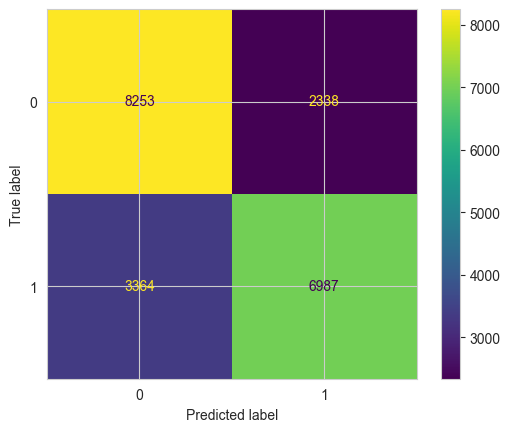

              precision    recall  f1-score   support

           0       0.71      0.78      0.74     10591
           1       0.75      0.68      0.71     10351

    accuracy                           0.73     20942
   macro avg       0.73      0.73      0.73     20942
weighted avg       0.73      0.73      0.73     20942



In [ ]:
# Results from model
cm = confusion_matrix(y_test_2, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()
print(classification_report(y_test_2, y_pred))


---

### Slutsats

I valet av modell vägde recall tyngst. I en situation där en sjukdom ska förutses är falska negativa särskilt allvarliga – vi vill inte att någon som löper risk eller redan har sjukdomen ska förbli oupptäckt. Detta gällde för alla bedömningar som gjordes kring parametrar, modeller, dataset och skalning, samt hur GridSearch utvärderade modeller och parametrar.

F1-score togs också med i bedömningen som ett sätt att få ett medelvärde för modellen under GridSearch.

Vid valet mellan Voting Classifier och den bästa modellen från GridSearch, Random Forest, hade Random Forest ett litet övertag. Eftersom accuracy och F1-score var desamma, men Voting Classifier hade bättre precision, blev recall avgörande. Random Forest hade högre recall, vilket vägde tyngst i modellvalet.